In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openpyxl

### Scrape spectral data

In [2]:
dframe = openpyxl.load_workbook("../data/Mineral spectra with ASD v2.xlsx")

In [3]:
endMemMap = {}

for tendMem in dframe.sheetnames :    
    endMem = tendMem.lower()
    
    if tendMem not in endMemMap :
        endMemMap[endMem] = {}
        endMemMap[endMem]["ASD wavelength"]  = []
        endMemMap[endMem]["ASD reflectance"] = []
    
    for row in dframe[tendMem].iter_rows(2,dframe[tendMem].max_row):
        endMemMap[endMem]["ASD wavelength"]  += [row[0].value]
        endMemMap[endMem]["ASD reflectance"] += [row[1].value]

In [4]:
dframe = openpyxl.load_workbook("../data/Mineral spectra with BECK v2.xlsx")

In [5]:
for tendMem in dframe.sheetnames :
    endMem = tendMem.lower()

    if tendMem not in endMemMap :
        endMemMap[endMem] = {}
        endMemMap[endMem]["BECK wavelength"]  = []
        endMemMap[endMem]["BECK reflectance"] = []
        
    if "ASD wavelength" in endMemMap[endMem] :
        print("\t - ",tendMem," has both BECK and ASD spectra.")
        
    for row in dframe[tendMem].iter_rows(2,dframe[tendMem].max_row):
        endMemMap[endMem]["BECK wavelength"]  += [row[0].value]
        endMemMap[endMem]["BECK reflectance"] += [row[1].value]

In [6]:
dframe    = openpyxl.load_workbook("../data/Mineral spectra with stated peaks v2.xlsx")
asdNames  = "Calcite,Gibbsite,Goethite,Kaolinite,Montmorillonite".split(',')
beckNames = "Ammonio-Smectite,Hematite,Illite".split(',')

In [7]:
for tendMem in dframe.sheetnames :
    endMem = tendMem.lower()
    
    ttype = "ASD"
    if tendMem in beckNames :
        ttype = "BECK"
            
    if tendMem not in endMemMap :
        endMemMap[endMem] = {}
        endMemMap[endMem][ttype+" wavelength"]  = []
        endMemMap[endMem][ttype+" reflectance"] = []
    
    if "ASD wavelength" in endMemMap[endMem] and "BECK wavelength" in endMemMap[endMem] :
        print("\t - ",tendMem," has both BECK and ASD spectra.")
        
    for row in dframe[tendMem].iter_rows(2,dframe[tendMem].max_row):
        endMemMap[endMem][ttype+" wavelength"]  += [row[0].value]
        endMemMap[endMem][ttype+" reflectance"] += [row[1].value]

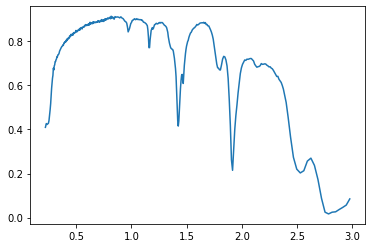

In [8]:
plt.plot(endMemMap["analcime"]["BECK wavelength"],endMemMap["analcime"]["BECK reflectance"])

### Scrape size, density, and other data

In [9]:
dframe = openpyxl.load_workbook("../data/Soil endmember mastersheet v2.xlsx")

Get chemical formula data, absorption peaks, and USGS reference information:

In [10]:
for row in dframe["USGS_spectra"].iter_rows(2,dframe["USGS_spectra"].max_row):
    if row[2].value is None : continue
    tendMem = row[2].value
    endMem = tendMem.lower()
    
    if endMem not in endMemMap :
        print("\t - Key not in endmember map:",endMem)
        continue
        
    endMemMap[endMem]["Chemical formula"] = row[3].value
    endMemMap[endMem]["Absorption peaks (nm)"] = row[4].value
    endMemMap[endMem]["USGS Library Spectrum Title"] = row[6].value
    endMemMap[endMem]["USGS Notes"] = row[8].value

Get mineral information:

In [11]:
for row in dframe["Minerals"].iter_rows(2,dframe["Minerals"].max_row):
    if row[1].value is None : continue
    tendMem = row[1].value
    endMem = tendMem.lower()
    
    if row[7].value != "TRUE" : continue
    
    if endMem not in endMemMap :
        print("\t - Mineral has USGS spectrum but is not in endmember map:",endMem)
        endMemMap[endMem] = {}
        
    if "Chemical formula" not in endMemMap[endMem] :
        endMemMap[endMem]["Chemical formula"] = row[2].value
    endMemMap[endMem]["Mineral class"] = row[3].value
    if row[4].value is not None :
        endMemMap[endMem]["Silicate class"] = row[4].value
    if row[5].value is not None :
        endMemMap[endMem]["Silicate mineral subclass"] = row[5].value
    endMemMap[endMem]["Mineral absorption peaks (nm)"] = row[8].value
    endMemMap[endMem]["Mineral absorption widths (nm)"] = row[9].value
    endMemMap[endMem]["Minerals Notes"] = row[15].value

Get mass densities and radii:

In [12]:
for row in dframe["density_radius"].iter_rows(2,dframe["density_radius"].max_row):
    if row[2].value is None : continue
    tendMem = row[2].value
    endMem = tendMem.lower()
        
    # for now, skip if not in the USGS spectrum list
    if endMem not in endMemMap : 
        #print("\t - Skipping mineral:",endMem)
        continue
    
    trho = row[7].value
    trad = row[10].value
    
    if trho is None :
        if row[8].value is not None :
            trho = row[8].value
        elif row[9].value is not None :
            trho = row[9].value
        else :
            print("\t - Mineral has no density data:",endMem)
        
    if trad is None :
        print("\t - Mineral has no radius data:",endMem)
    
    # calculate actual density from table entry
    if isinstance(trho,float) : 
        rho = trho 
    elif trho is None : 
        rho = None
    else : np.mean(np.array([float(x) for x in trho.split('-')]))
    
    # calculate actual radius from table entry
    if isinstance(trad,float) : 
        rad = trad
    elif trad is None :
        rad = None
    else :
        rad = trad.split(',')[0]
        rad = rad.split('*')
        rad = [np.mean(np.array([float(x) for x in y.split('-')])) for y in rad]
        rad = np.prod(np.array(rad))
        rad = (rad * 3./4. / np.pi) ** (1./3.)
    
    # save data
    endMemMap[endMem]["Density (Mg/m^3)"] = rho
    endMemMap[endMem]["Effective Radius (nm)"] = rad    

#### Compute molecular mass, carbon content

In [13]:
endMemMap["calcite"]["Chemical formula"] = "CaCO3"

endMemMap["calcite"]["Carbon % by mass"] = 0.12
endMemMap["hydromagnesite"]["Carbon % by mass"] = 0.1027
endMemMap["dolomite"]["Carbon % by mass"] = 0.1303
endMemMap["siderite"]["Carbon % by mass"] = 0.1037
endMemMap["aragonite"]["Carbon % by mass"] = 0.12
endMemMap["magnesite"]["Carbon % by mass"] = 0.1425
endMemMap["trona"]["Carbon % by mass"] = 0.1063

for x in endMemMap.keys() :
    endMemMap[x]["Carbon % by mass"] = 0.0 if "Carbon % by mass" not in endMemMap[x] else endMemMap[x]["Carbon % by mass"]

In [14]:
[(x, endMemMap[x]["Chemical formula"],endMemMap[x]["Carbon % by mass"]) if "Chemical formula" in endMemMap[x] else (x,None,endMemMap[x]["Carbon % by mass"]) for x in endMemMap]

[('pyrolusite', 'MnO2', 0.0),
 ('fluorapatite', 'Ca5(PO4)3F', 0.0),
 ('halloysite', 'Al2Si2O5(OH)4', 0.0),
 ('actinolite', 'Ca2(Mg, Fe)5Si8O22(OH)2', 0.0),
 ('albite', 'NaAlSi3O8', 0.0),
 ('anorthite', 'CaAl2Si3O8', 0.0),
 ('beryl', 'Be3Al2(Si6O18)', 0.0),
 ('chlorite', '(Mg, Fe)3(Si, Al)4O10(OH)2-(Mg, Fe)3(OH)6', 0.0),
 ('chrysotile', 'Mg3Si2O5(OH)4', 0.0),
 ('corundum', 'Al2O3', 0.0),
 ('cummingtonite', '(Mg, Fe)7Si8O22(OH)2', 0.0),
 ('diaspore', 'AlOOH', 0.0),
 ('diopside', 'CaMgSi2O6', 0.0),
 ('dolomite', 'CaMg(CO3)2', 0.1303),
 ('epidote', 'Ca2(Al,Fe)Al2O(SiO4)(Si2O7)(OH)', 0.0),
 ('forsterite', 'Mg2SiO4', 0.0),
 ('gypsum', 'CaSO4·2H2O', 0.0),
 ('halite', 'NaCl', 0.0),
 ('hedenbergite', 'CaFeSi2O6', 0.0),
 ('hornblende', '(Ca, Na)2-3(Mg,Fe,Al)5Si6-(Si, Al)2O22(OH)2', 0.0),
 ('ilmenite', 'FeTiO3', 0.0),
 ('magnetite', 'Fe3O4', 0.0),
 ('muscovite', 'KAl2(AlSi3O10)(OH)2', 0.0),
 ('nepheline', '(Na, K)AlSiO4', 0.0),
 ('phlogopite', 'KMg3(AlSi3O10)(OH)2', 0.0),
 ('pyrite', 'FeS2', 0.0)

#### Add in cross-spectra general information

In [15]:
endMemMap["General"] = {}
endMemMap["General"]["Postprocessed Wavelength Axis [nm]"] = [x for x in range(350,2501)]

#### Check that the axes are not too different within measurement classes

0.34999999 2.5


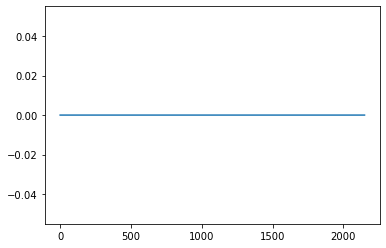

In [16]:
bla=[endMemMap[x]["ASD wavelength"] if "BECK wavelength" not in endMemMap[x] and x != "General" else None for x in endMemMap.keys()]
bla=[x for x in bla if x is not None]
bla=np.array(bla)
plt.plot(np.max(bla,axis=0) - np.min(bla,axis=0))
print(np.min(bla),np.max(bla))

0.2051 2.9760001


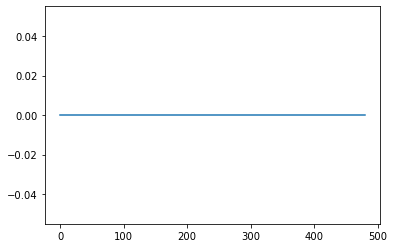

In [17]:
bla=[endMemMap[x]["BECK wavelength"] if "ASD wavelength" not in endMemMap[x] and x !="General" else None for x in endMemMap.keys()]
bla=[x for x in bla if x is not None]
bla=np.array(bla)
plt.plot(np.max(bla,axis=0) - np.min(bla,axis=0))
print(np.min(bla),np.max(bla))

### Postprocess ASD and BECK spectra to be on the same XF

In [18]:
def postProcessSpectrum(xin,xout,refin) :
    return np.interp(xout, xin, refin)

for endMem in endMemMap :
    if endMem == "General" : continue
    
    ttype = "BECK"
    if "ASD wavelength" in endMemMap[endMem] :
        ttype = "ASD"
            
    wavelengths = np.array(endMemMap[endMem][ttype+" wavelength"])
    reflectance = np.array(endMemMap[endMem][ttype+" reflectance"])
    
    newwave = np.array([wavelengths[i] for i in range(len(wavelengths)) if reflectance[i] is not None])
    newref  = np.array([reflectance[i] for i in range(len(reflectance)) if reflectance[i] is not None])
    
    XF = np.array([x for x in range(350,2501)])
    
    endMemMap[endMem]["Postprocessed Reflectance"] = postProcessSpectrum(newwave*1000.0,XF,newref).tolist()

### Summarize changes to mastersheets and export JSON

Changes made to soil endmember mastersheet:

- density_radius: "chlorites -> chlorite"
- density_radius: "hematite/haematite -> hematite"
- density_radius: "smectite -> ammonio-smectite"
- density_radius: "hydroxyapatite -> hydroxyl-apatite"
- density_radius: "chloroapatite -> chlorapatite"
- USGS_spectra: "chlorites -> chlorite"
- USGS_spectra: "chloroapatite -> chlorapatite"
- USGS_spectra: "hydroxyapatite -> hydroxyl-apatite"
- USGS_spectra: "fluoroapatite -> fluorapatite"

In ASD spectra: 

- Duplicate "Magnesite+Hydromag" and turn into two sheets, "Magnesite" and "Hydromagnesite"

In [19]:
import json
with open('endmember spectral data.json', 'w', encoding='utf-8') as f:
    json.dump(endMemMap, f, ensure_ascii=False, indent=4)

### Plot spectra

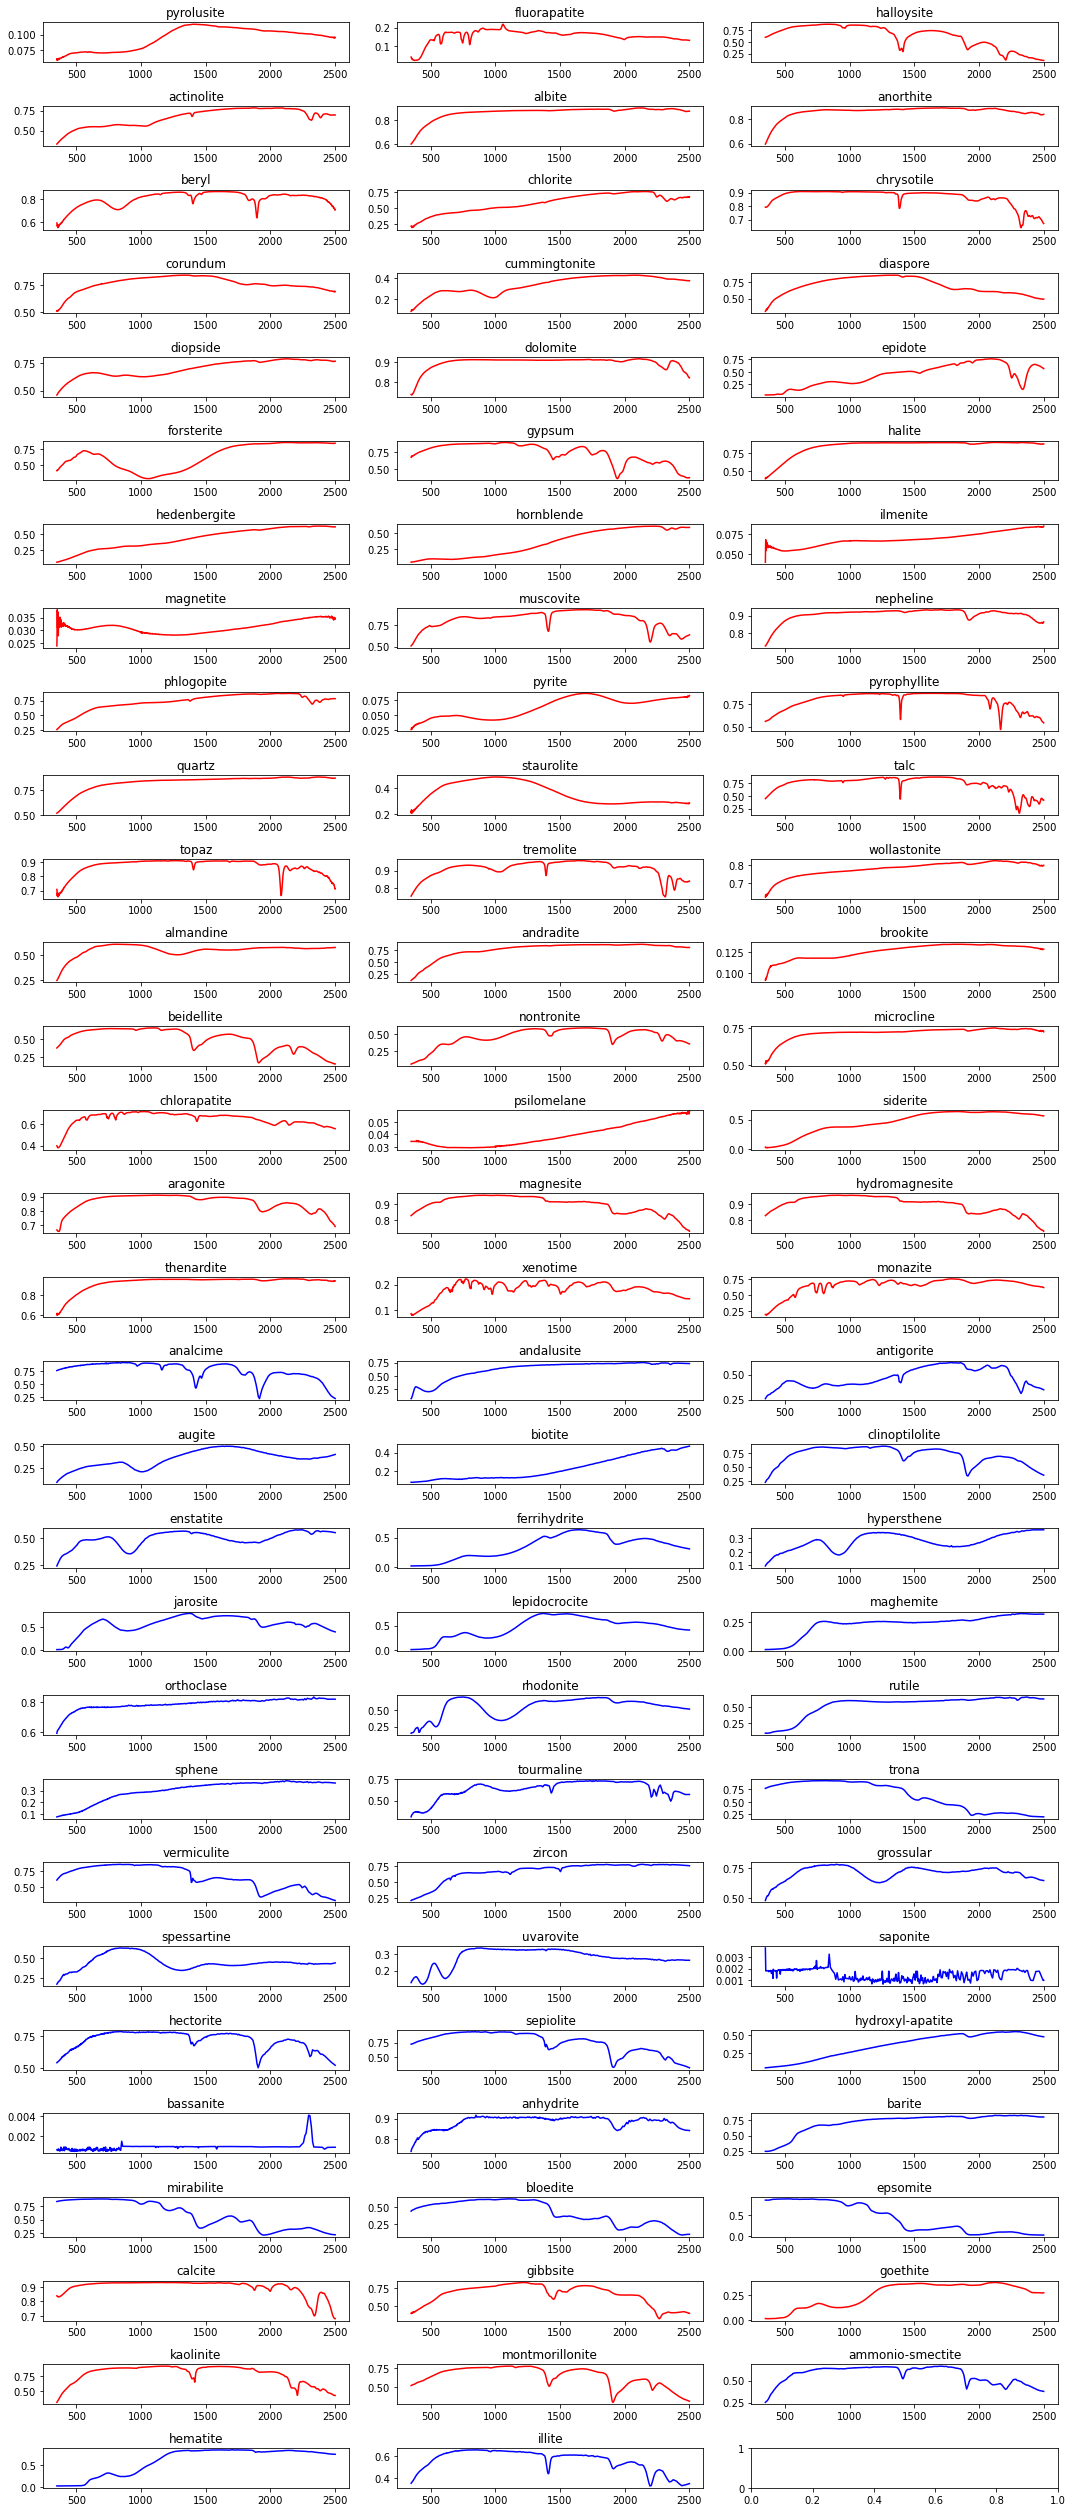

In [20]:
f, axarr = plt.subplots(int(np.ceil((len(endMemMap.keys())-1)/3.)),3,figsize=(15,35))

curr_row = 0
index = 0

for endMem in endMemMap.keys():
    if endMem == "General" : continue

    if "ASD wavelength" in endMemMap[endMem] :
        ttype="ASD"
        clr = "r"
    else: 
        ttype = "BECK"
        clr = "b"
        
    #a = plt.plot(endMemMap[endMem][ttype+" wavelength"],endMemMap[endMem][ttype+" reflectance"])

    # find the column by taking the current index modulo 3
    col = index % 3
    # plot on relevant subplot
    axarr[curr_row,col].plot(endMemMap["General"]["Postprocessed Wavelength Axis [nm]"],endMemMap[endMem]["Postprocessed Reflectance"],clr)
    axarr[curr_row,col].set_title(endMem)
    
    plt.ylim([0,1])
        
    # we have finished the current row, so increment row counter
    if col == 2 :
        curr_row += 1
    index +=1
    
    
f.tight_layout()
plt.show()